This notebook creates and then trains naive templates

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pickle
from scipy.interpolate import interp1d

from modules import get_bandpass_dict, get_eff_wavelen, Sed, \
                    create_training_sets, train_templates

In [2]:
# plotting style
%config InlineBackend.figure_format = 'retina'
plt.style.use('paper.mplstyle')
twocol = 7.1014
onecol = 3.35

Load the filters

In [3]:
bandpass_dict = get_bandpass_dict()

Load the galaxy redshift catalog

In [4]:
with open('data/galaxy_catalog.pkl', 'rb') as input:
    galaxies = pickle.load(input)

Create the naive templates

In [41]:
def log_norm(x,mode,sigma,A):
    mu = np.log(mode) + sigma**2
    f1 = lambda x: 1e5/(x*sigma*np.sqrt(2*np.pi))*np.exp(-(np.log(x)-mu)**2/(2*sigma**2))
    f = lambda x: A/f1(mode)*f1(x)
    return f(x)

N = 20
modes = np.linspace(5000,1000,N)
sigmas = np.linspace(0.6,0.8,N)
As = np.concatenate([np.linspace(0.1,1,6,endpoint=False),
                     np.linspace(1,10,N-4)])

# save the templates as Seds
x = np.linspace(10,23500,100)
naive_templates = dict()
for i in range(N):
    template = Sed()
    template.wavelen = x
    template.flambda = log_norm(x,modes[i],sigmas[i],As[i])
    naive_templates["naive"+str(i+1)] = template

Create training sets and plot them

In [6]:
%%time
training_sets = create_training_sets(naive_templates,galaxies,bandpass_dict)

CPU times: user 2min 50s, sys: 228 ms, total: 2min 50s
Wall time: 2min 50s


Number of fluxes in each training set:
[95751, 7678, 8464, 10008, 10819, 11004, 11458, 10538, 10335, 9651, 8090, 8145, 7298, 6971, 6657, 6615, 6874, 6505, 5998, 11619]


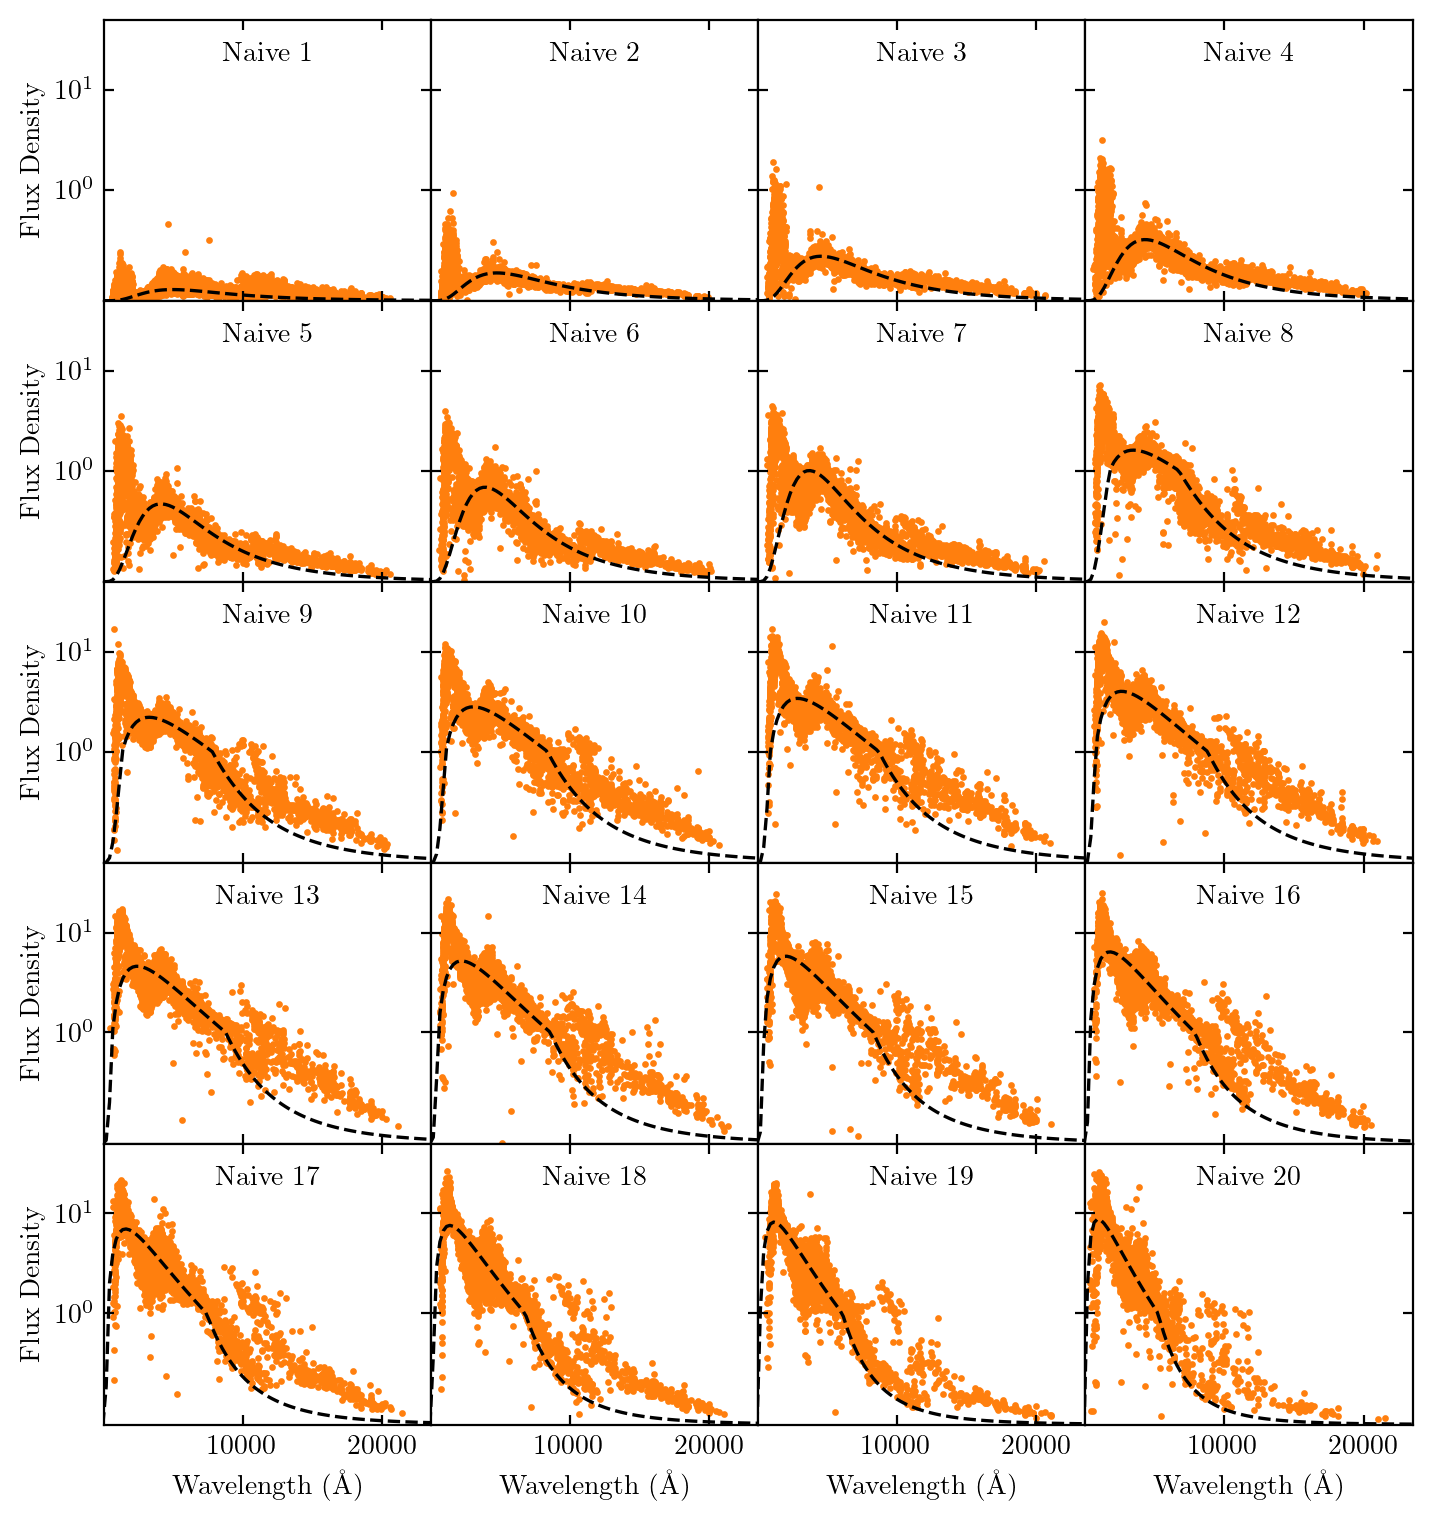

In [43]:
ncols = 4
nrows = int(N/ncols+0.5)
fig, axes = plt.subplots(nrows,ncols,sharex='all',sharey='all',figsize=(twocol,twocol*nrows/ncols*0.85))

print("Number of fluxes in each training set:")
print([len(i) for i in training_sets.values()])

for i,ax in enumerate(axes.flatten()):
    
    wavelen = [row[0] for row in training_sets["naive"+str(i+1)]]
    fluxes  = [row[1] for row in training_sets["naive"+str(i+1)]]
    ax.scatter(wavelen, fluxes, s=2, c="C1")
    
    template = naive_templates["naive"+str(i+1)]
    ax.plot(template.wavelen, template.flambda, ls="--", c="k")
    
    ax.text(0.5,0.85,"Naive "+str(i+1),transform=ax.transAxes,ha="center")
    
plt.xlim(100,23500)
plt.ylim(0,50)
plt.yscale('symlog',linthreshy=1)
for ax in axes[-1,:]:
    ax.set_xlabel('Wavelength ($\mathrm{\AA}$)')
for ax in axes[:,0]:
    ax.set_ylabel('Flux Density')
    
plt.yticks([1,10])

fig.tight_layout(pad=0.5, h_pad=0, w_pad=0)
plt.show()

#fig.savefig('plots/naive_untrained.pdf')

Now train the templates

In [15]:
%%time
trained_templates, final_sets = train_templates(naive_templates, galaxies, bandpass_dict, N_iter=1, w=0.75)

Round 1/5
0.0026654681425970434
0.005560750751536638
0.005152475238966624
0.004483123710827733
0.004192384582277582
0.004168498299132216
0.0040844594193134584
0.004195827455165822
0.00427741508447247
0.00448405443280102
0.004914747602879446
0.005060802944038416
0.005257477905370458
0.005336654677590853
0.005445505304588824
0.005391107761270608
0.0055088093110500355
0.005794725167898979
0.006303137728643788
0.010245281317347697
Round 2/5
0.0033461592000435685
0.0033525916590160815
0.006475435165243735
0.00545467130658148
0.003436055488496172
0.006597398810560823
0.0063261878815346105
0.005221540843416318
0.0036580537850860175
0.007116994318109204
0.004007393527705059
0.003908876253328993
0.008307704110082366
0.002661413580809465
0.008271259375998685
0.008851343787310327
0.004309582520362163
0.004661699347657556
0.015697032389125638
0.012978474822165726
Round 3/5
0.0038307482052684252
0.003248033085608853
0.006240317603506126
0.005202149446032254
0.003071728728237608
0.006616871986329419

Number of fluxes in each training set:
[53755, 27090, 14281, 11704, 19123, 5375, 5627, 7232, 18134, 6532, 9780, 17038, 5954, 22323, 4198, 5026, 10702, 9274, 4158, 3172]


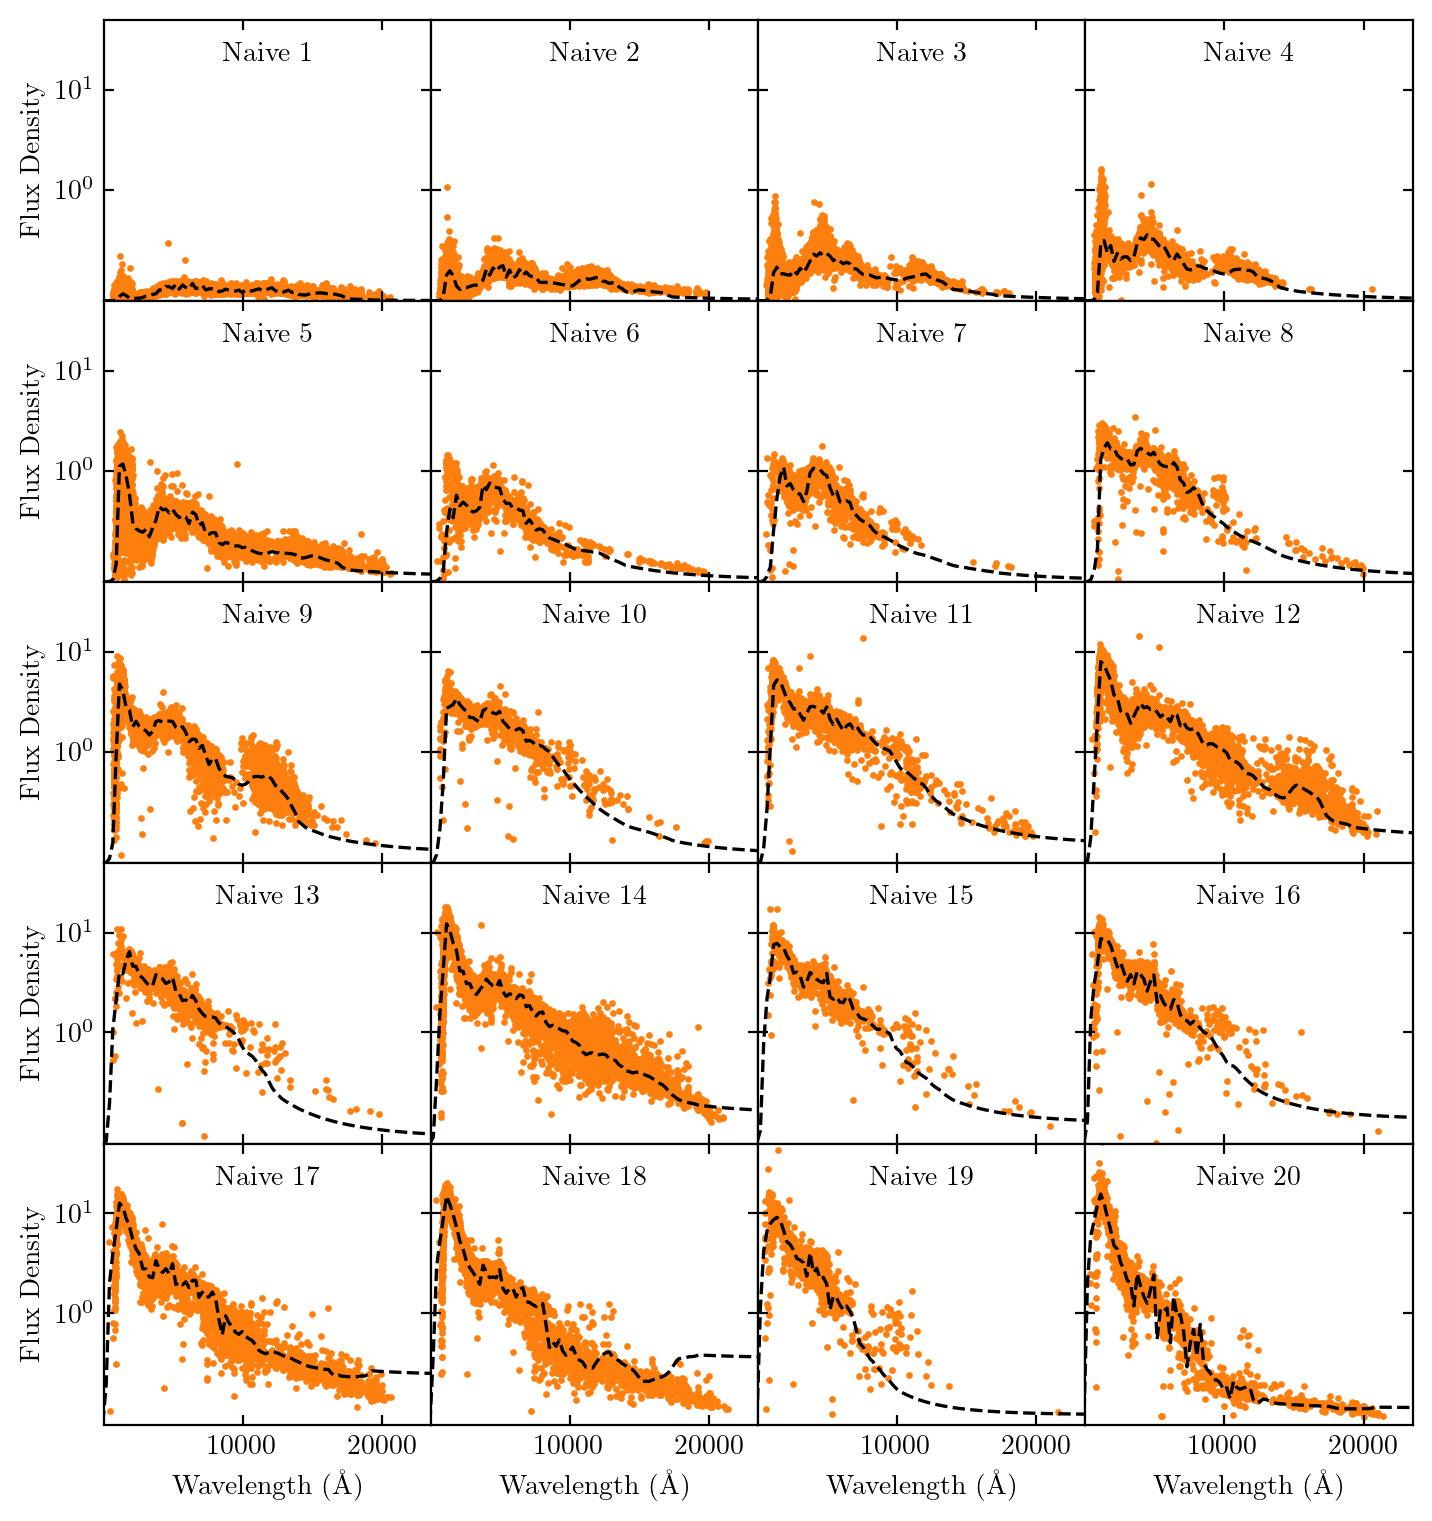

In [46]:
ncols = 4
nrows = int(N/ncols+0.5)
fig, axes = plt.subplots(nrows,ncols,sharex='all',sharey='all',figsize=(twocol,twocol*nrows/ncols*0.85))

print("Number of fluxes in each training set:")
print([len(i) for i in final_sets.values()])

for i,ax in enumerate(axes.flatten()):
    
    wavelen = [row[0] for row in final_sets["naive"+str(i+1)]]
    fluxes  = [row[1] for row in final_sets["naive"+str(i+1)]]
    ax.scatter(wavelen, fluxes, s=2, c="C1")
    
    template = trained_templates["naive"+str(i+1)]
    ax.plot(template.wavelen, template.flambda, ls="--", c="k")
    
    ax.text(0.5,0.85,"Naive "+str(i+1),transform=ax.transAxes,ha="center")
    
plt.xlim(100,23500)
plt.ylim(0,50)
plt.yscale('symlog',linthreshy=1)
for ax in axes[-1,:]:
    ax.set_xlabel('Wavelength ($\mathrm{\AA}$)')
for ax in axes[:,0]:
    ax.set_ylabel('Flux Density')
    
plt.yticks([1,10])

fig.tight_layout(pad=0.5, h_pad=0, w_pad=0)
plt.show()

#fig.savefig('plots/naive_trained.pdf')

Save the results!

In [36]:
for template in trained_templates:
    file = open('templates/'+template+'.sed','w')
    x = trained_templates[template].wavelen
    y = trained_templates[template].flambda
    for i in range(len(x)):
        file.write("{0:<10.2f}{1:<10.2f}\n".format(x[i],y[i]))
    file.close()

Plot the naive templates with the CWW+SB4 Templates

In [37]:
cwwsb4 = ['El_B2004a', 'Sbc_B2004a', 'Scd_B2004a', 'Im_B2004a', 'SB3_B2004a', 
                'SB2_B2004a', 'ssp_25Myr_z008', 'ssp_5Myr_z008']

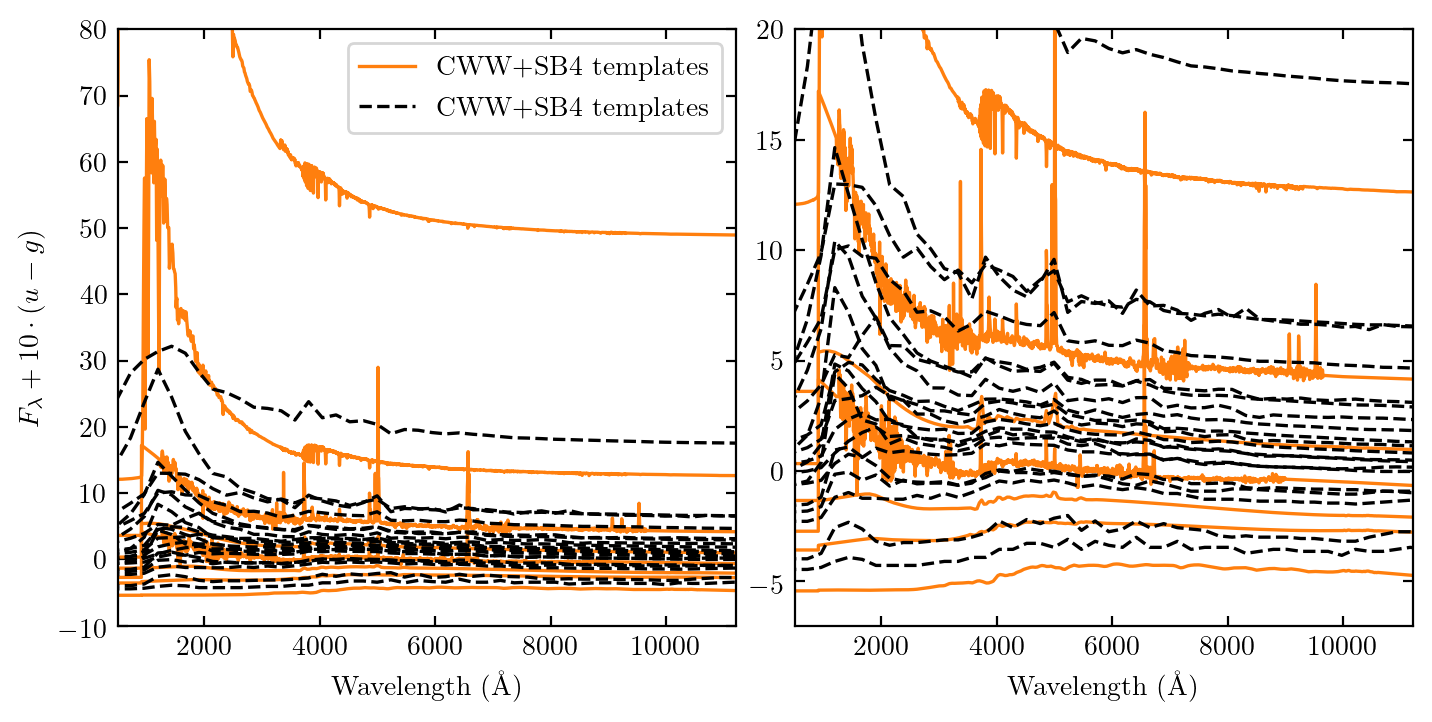

In [38]:
fig, (ax1,ax2) = plt.subplots(1,2,figsize=(twocol,twocol/2))

colors = ['C1','k']
styles = ['-','--']
titles = ['CWW+SB4 templates', "Naive templates"]
for i,template_set in enumerate([cwwsb4,trained_templates]):

    for template in template_set:
        name = 'templates/'+template+'.sed'
        x,y = np.loadtxt(name,unpack=True)
        f = interp1d(x,y)
        y /= f(8000)

        sed = Sed()
        sed.wavelen = x
        sed.flambda = y

        u = sed.flux(bandpass_dict['u'])
        g = sed.flux(bandpass_dict['g'])
        template_fluxes = sed.fluxlist(bandpass_dict)
        
        ax1.plot(x,y+10*(u-g),c=colors[i],ls=styles[i])
        ax2.plot(x,y+10*(u-g),c=colors[i],ls=styles[i])

ax1.plot([5000],[30],c='C1',label='CWW+SB4 templates')
ax1.plot([5000],[30],c='k',ls='--',label='CWW+SB4 templates')
ax1.legend()

ax1.set_ylim(-10,80)
ax1.set_xlim(500,11200)
ax1.set_ylabel('$F_\lambda + 10 \cdot (u-g)$') 
ax1.set_xlabel('Wavelength ($\mathrm{\AA}$)')

ax2.set_ylim(-7,20)
ax2.set_xlim(500,11200)
ax2.set_xlabel('Wavelength ($\mathrm{\AA}$)')

fig.tight_layout(pad=0.5)
#fig.savefig("plots/naive_vs_cwwsb4.pdf")
plt.show()